### Game Theory: The Shapley value applied to attribution Models in Marketing

We take a typical case in which we are provided the different investments made in marketing in an specifix period of time to make conversions.
Let's say we invested on the following channels to obtain 1000 convertions.

***********************************
CHANNEL               CONVERSION   
***********************************
SEM		                150
DISPLAY		            300
SEO		                100
SEM	+ DISPLAY	        350
SEM	+ SEO	            250
DISPLAY + SEO	        400
DISPLAY	 + SEO +  SEM	480
***********************************
Our goal is to determine the optimal performance of the channels based on the former information and the game theory. In doing so we use the Shapley formula


**The characteristic function**

A game is defined by a set of players N and a characteristic function v. Every subset of players is called a coalition S, and the characteristic function v(S) assigns a value to each coalition to signify its worth. A coalition’s worth represents the payoff that it can generate when its players work together.

Options for defining the characteristic function for marketing include:

Total revenue generated by each coalition
Total number of sales conversions generated by each coalition
Conversion ratio of each coalition (conversions / opportunities)
Conditional probability of conversion — likelihood of converting given a set of channels

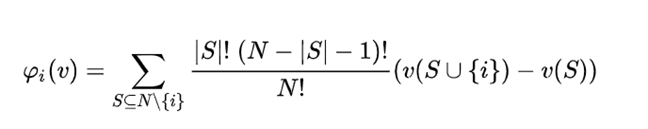

In [21]:
import warnings
import numpy as np
import pandas as pd
from   itertools import combinations

warnings.filterwarnings(action='ignore')

def subsets(S):
    '''Yield all possible subsets from S'''
    s = []
    for i in range(1, len(S)+1):
        s.extend(map(list, combinations(S, i)))
    return list(map('+'.join, s))

N = sorted({'sem', 'seo', 'display'})

coalitions = subsets(N)
coalitions_lbl = ['S{}'.format(i) for i in range(1, len(coalitions)+1)]

#List of convertions per channel combination
tlist = np.array([300.00, 150.00, 100.00, 350.00, 400.00, 250.0, 480.00])
#tlist in percentages
IR = tlist / tlist.sum()
#print(IR)
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame({
    'canal': coalitions,
    'ratio': IR
}, dtype=np.float64, index=coalitions_lbl)

,canal,ratio
S1,display,0.15
S2,sem,0.07
S3,seo,0.05
S4,display+sem,0.17
S5,display+seo,0.20
S6,sem+seo,0.12
S7,display+sem+seo,0.24


In [22]:
# Create a binary matrix B which represents the channel distribution.
# For exaple to obtain the SEO + SEM set, we use the following channels:
# - SEO
# - SEM
# - SEO + SEM
# In doing so, we generate the following coefficients: [0,1,1,0,0,1,0]

d = 2**len(N)-1 
B = np.matrix(np.zeros((d, d)))

for i in range(0, d):
    A = coalitions[i]
    S = subsets(A.split('+'))
    coef = [1 if c in S else 0 for c in coalitions]
    B[i] = coef

pd.options.display.float_format = '{:,.0f}'.format
pd.DataFrame(data=B, index=coalitions, columns=coalitions)

,display,sem,seo,display+sem,display+seo,sem+seo,display+sem+seo
display,1,0,0,0,0,0,0
sem,0,1,0,0,0,0,0
seo,0,0,1,0,0,0,0
display+sem,1,1,0,1,0,0,0
display+seo,1,0,1,0,1,0,0
sem+seo,0,1,1,0,0,1,0
display+sem+seo,1,1,1,1,1,1,1


In [23]:
# We perform the dot product of matrix B and IR to obtain the v(s) value per channel

vS = np.dot(B, IR)
vS = np.squeeze(np.asarray(vS))

vSx = ['v({})'.format(lbl) for lbl in coalitions_lbl]
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame({
    'Coalition': coalitions,
    'Worth': vS
}, index=vSx)

,Coalition,Worth
v(S1),display,0.15
v(S2),sem,0.07
v(S3),seo,0.05
v(S4),display+sem,0.39
v(S5),display+seo,0.39
v(S6),sem+seo,0.25
v(S7),display+sem+seo,1.00


In [24]:
from collections import defaultdict
from math        import factorial

# We calculatethe Shapley value as the average marginal contribution per channel.
# Take into account all the possible combinations between channels.

shapley = defaultdict(int)
n = len(N)

for i in N:
    for A in coalitions:
        S = A.split('+')
        if i not in S:
            k = len(S) # Cardinality of set |S|
            Si = S
            Si.append(i)
            Si = '+'.join(sorted(Si))
            # Weight = |S|!(n-|S|-1)!/n!
            weight = (factorial(k) * factorial(n-k-1)) / factorial(n)
            # Marginal contribution = v(S U {i})-v(S)
            contrib = vS[coalitions.index(Si)] - vS[coalitions.index(A)]            
            shapley[i] += weight * contrib
    shapley[i] += vS[coalitions.index(i)]/n

In [25]:
tot_conversions = 1000
pd.options.display.float_format = '{:,.3f}'.format
df_optimal = pd.DataFrame({
    'shapley_value': list(shapley.values())
}, index=list(shapley.keys()))
df_optimal['shapley_conversion'] = df_optimal['shapley_value']*tot_conversions
display(df_optimal)
 

,shapley_value,shapley_conversion
display,0.411,411.330
sem,0.300,300.493
seo,0.288,288.177


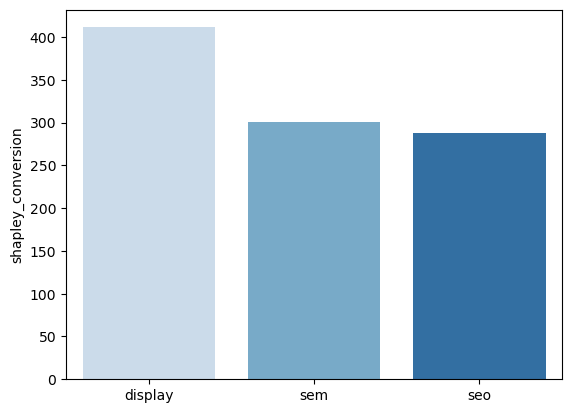

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(df_optimal.index, 
            df_optimal.shapley_conversion,
            palette='Blues'           
            )
plt.show()
# We finally display the optimal distribution per channel.
# In this case, "Display" was the channel with better performance in the campaign.